# **Importing all necessary libraries**

In [ ]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# **Setting random seed**

In [ ]:
seed=1234
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
set_seed(seed)

Random seed set as 1234


# **Loading dataset, and saving it to the array**

In [ ]:
dataset=tfds.load('oxford_iiit_pet',split='train+test',shuffle_files=True)
ds_numpy=np.vstack(tfds.as_numpy(dataset))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete2HAFCF/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete2HAFCF/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


In [ ]:
img_size=128
X=np.zeros(shape=(ds_numpy.shape[0],img_size,img_size,3),dtype='uint8')
for i in range(ds_numpy.shape[0]):
    img=cv2.resize(ds_numpy[i][0]['image'],(img_size,img_size))
    X[i]=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
y=np.array(list(map(lambda x:x[0]['label'],ds_numpy)))
print(X.shape)
print(y.shape)

(7349, 128, 128, 3)
(7349,)


# **Visualizing some images from dataset**

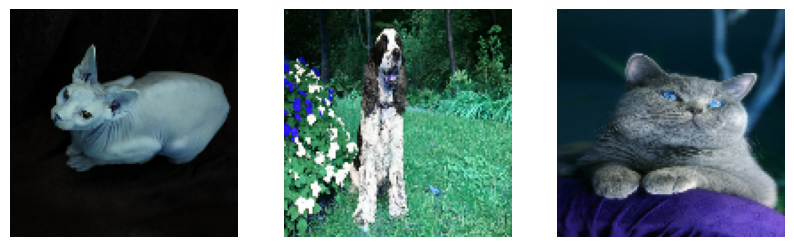

In [ ]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,3,1)
ax.axis('off')
ax.imshow(X[0])
ax=fig.add_subplot(1,3,2)
ax.axis('off')
ax.imshow(X[1])
ax=fig.add_subplot(1,3,3)
ax.axis('off')
ax.imshow(X[2])
plt.show()

# **Splitting dataset, and converting to tensors**

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(X,y,random_state=1,train_size=0.925)
X_train_l,X_train_u,y_train_l,y_train_u=train_test_split(X_train,y_train,random_state=1,train_size=0.3)
print(X_train.shape)
print(y_train.shape)
print(X_train_l.shape)
print(y_train_l.shape)
print(X_train_u.shape)
print(y_train_u.shape)
print(X_val.shape)
print(y_val.shape)

(6797, 128, 128, 3)
(6797,)
(2039, 128, 128, 3)
(2039,)
(4758, 128, 128, 3)
(4758,)
(552, 128, 128, 3)
(552,)


In [ ]:
BATCH_SIZE=128
X_train=tf.convert_to_tensor(X_train)
print(X_train.shape)
y_train=tf.convert_to_tensor(y_train)
print(y_train.shape)
X_val=tf.convert_to_tensor(X_val)
print(X_val.shape)
y_val=tf.convert_to_tensor(y_val)
print(y_val.shape)
X_train_l=tf.convert_to_tensor(X_train_l)
print(X_train_l.shape)
y_train_l=tf.convert_to_tensor(y_train_l)
print(y_train_l.shape)
X_train_u=tf.convert_to_tensor(X_train_u)
print(X_train_u.shape)
train_data=tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(BATCH_SIZE)
train_labeled_data=tf.data.Dataset.from_tensor_slices((X_train_l,y_train_l)).batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(BATCH_SIZE)

(6797, 128, 128, 3)
(6797,)
(552, 128, 128, 3)
(552,)
(2039, 128, 128, 3)
(2039,)
(4758, 128, 128, 3)


# **Learning model on a complete dataset**

In [ ]:
EPOCHS=20
base_model=tf.keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))
for layers in base_model.layers:
    layers.trainable=False
model=tf.keras.Sequential([base_model,
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dropout(0.65),
                           tf.keras.layers.Dense(units=128,activation='leaky_relu'),
                           tf.keras.layers.Dense(units=37,activation='softmax',kernel_regularizer=tf.keras.regularizers.L1(0.1))])
model.summary()
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['Accuracy'],run_eagerly=True)
hist=model.fit(train_data,validation_data=val_data,epochs=EPOCHS)

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 37)                4773      
                                                                 
Total params: 15768165 (60.15 MB)
Trainable params: 1053477 (4.02 MB)
Non-trainable params: 14714688 (56.13 MB)
___________

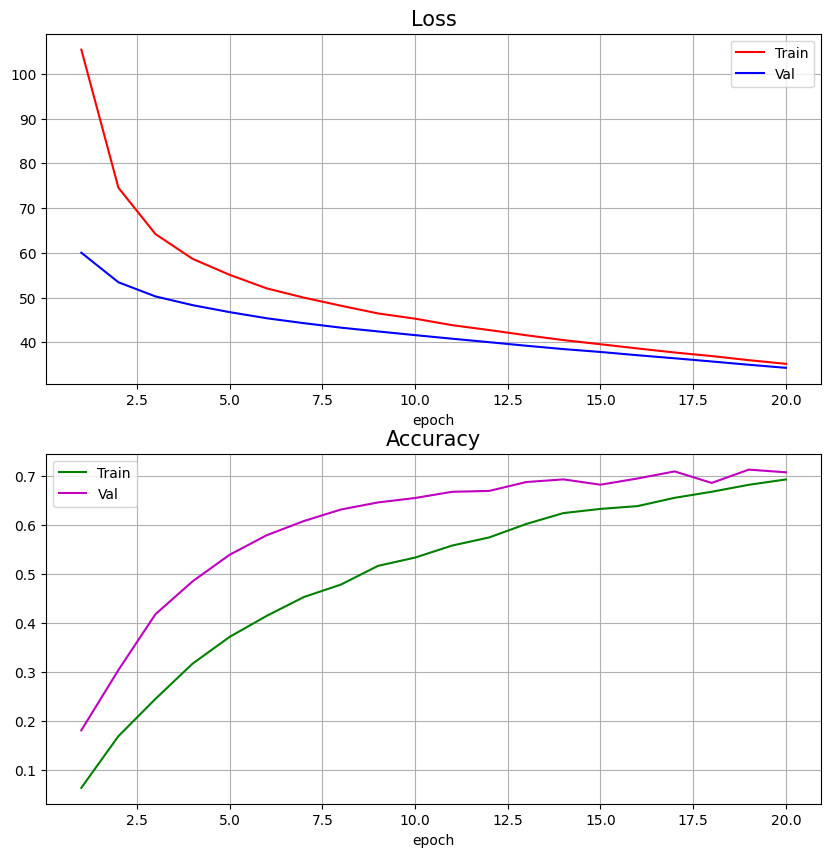

In [ ]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['Accuracy']
val_acc=hist.history['val_Accuracy']
epochs=[i for i in range(1,len(val_loss)+1)]
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(2,1,1)
ax1.set_title('Loss',fontsize=15)
ax1.plot(epochs,train_loss,color='r',label='Train')
ax1.plot(epochs,val_loss,color='b',label='Val')
ax1.set_xlabel('epoch')
ax1.grid()
ax1.legend()
ax2=fig.add_subplot(2,1,2)
ax2.set_title('Accuracy',fontsize=15)
ax2.plot(epochs,train_acc,color='g',label='Train')
ax2.plot(epochs,val_acc,color='m',label='Val')
ax2.set_xlabel('epoch')
ax2.grid()
ax2.legend()
plt.show()

In [ ]:
model.save_weights('/kaggle/working/weights_1.h5')

# **Learning first classification model**

In [ ]:
EPOCHS=30
base_model=tf.keras.applications.vgg19.VGG19(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))
for layers in base_model.layers:
    layers.trainable=False
model1=tf.keras.Sequential([base_model,
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dropout(0.8),
                           tf.keras.layers.Dense(units=256,activation='leaky_relu'),
                           tf.keras.layers.Dense(units=37,activation='softmax',kernel_regularizer=tf.keras.regularizers.L1(0.1))])
model1.summary()
model1.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['Accuracy'],run_eagerly=True)
hist=model1.fit(train_labeled_data,validation_data=val_data,epochs=EPOCHS)

80134624/80134624 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_1 (Dropout)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 37)                9509      
                                                                 
Total params: 22131301 (84.42 MB)
Trainable params: 2106917 (8.04 MB)
Non-trainable params: 20024384 (76.39 MB)
_________

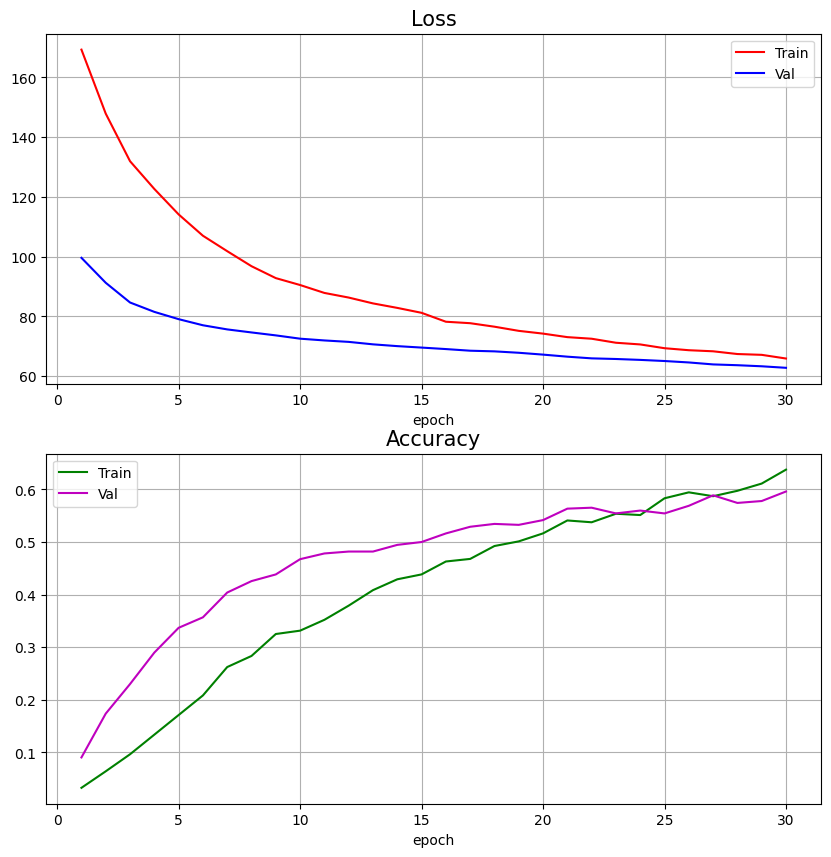

In [ ]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['Accuracy']
val_acc=hist.history['val_Accuracy']
epochs=[i for i in range(1,len(val_loss)+1)]
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(2,1,1)
ax1.set_title('Loss',fontsize=15)
ax1.plot(epochs,train_loss,color='r',label='Train')
ax1.plot(epochs,val_loss,color='b',label='Val')
ax1.set_xlabel('epoch')
ax1.grid()
ax1.legend()
ax2=fig.add_subplot(2,1,2)
ax2.set_title('Accuracy',fontsize=15)
ax2.plot(epochs,train_acc,color='g',label='Train')
ax2.plot(epochs,val_acc,color='m',label='Val')
ax2.set_xlabel('epoch')
ax2.grid()
ax2.legend()
plt.show()

# **Using first model for proxy-labeling**

In [ ]:
pseudo_labels_1=model1.predict(X_train_u)
pseudo_labels_1=np.array([np.argmax(x) for x in pseudo_labels_1])
print(pseudo_labels_1)

149/149 [==============================] - 5s 35ms/step
[ 1 30 36 ... 23 25  2]


In [ ]:
combined_data_1=np.concatenate([X_train_l,X_train_u],axis=0)
print(combined_data_1.shape)
combined_labels_1=np.concatenate([y_train_l,pseudo_labels_1],axis=0)
print(combined_labels_1.shape)
combined_data_1,combined_labels_1=shuffle(combined_data_1,combined_labels_1,random_state=1)
combined_data_1=tf.data.Dataset.from_tensor_slices((combined_data_1,combined_labels_1)).batch(BATCH_SIZE)

(6797, 128, 128, 3)
(6797,)


# **Learning second model**

In [ ]:
EPOCHS=30
base_model=tf.keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))
for layers in base_model.layers:
    layers.trainable=False
model2=tf.keras.Sequential([base_model,
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dropout(0.65),
                           tf.keras.layers.Dense(units=128,activation='leaky_relu'),
                           tf.keras.layers.Dense(units=37,activation='softmax',kernel_regularizer=tf.keras.regularizers.L1(0.1))])
model2.summary()
model2.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['Accuracy'],run_eagerly=True)
hist=model2.fit(train_labeled_data,validation_data=val_data,epochs=EPOCHS)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1048704   
                                                                 
 dense_5 (Dense)             (None, 37)                4773      
                                                                 
Total params: 15768165 (60.15 MB)
Trainable params: 1053477 (4.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/

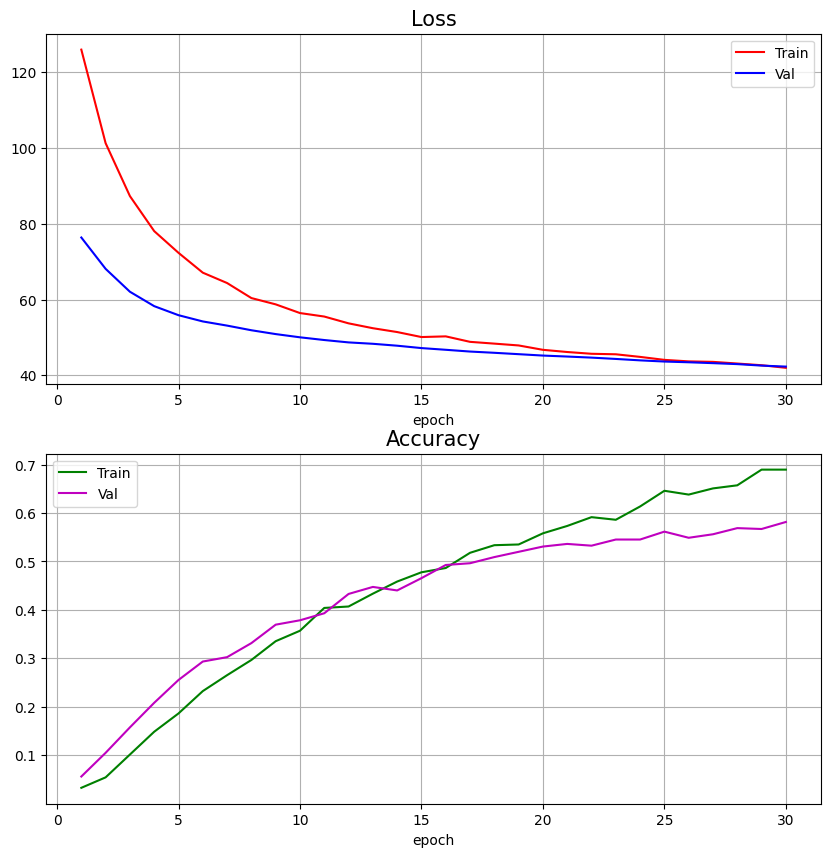

In [ ]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['Accuracy']
val_acc=hist.history['val_Accuracy']
epochs=[i for i in range(1,len(val_loss)+1)]
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(2,1,1)
ax1.set_title('Loss',fontsize=15)
ax1.plot(epochs,train_loss,color='r',label='Train')
ax1.plot(epochs,val_loss,color='b',label='Val')
ax1.set_xlabel('epoch')
ax1.grid()
ax1.legend()
ax2=fig.add_subplot(2,1,2)
ax2.set_title('Accuracy',fontsize=15)
ax2.plot(epochs,train_acc,color='g',label='Train')
ax2.plot(epochs,val_acc,color='m',label='Val')
ax2.set_xlabel('epoch')
ax2.grid()
ax2.legend()
plt.show()

# **Using second model for proxy-labeling**

In [ ]:
pseudo_labels_2=model2.predict(X_train_u)
pseudo_labels_2=np.array([np.argmax(x) for x in pseudo_labels_2])
print(pseudo_labels_2)

149/149 [==============================] - 5s 30ms/step
[15 30 36 ... 23 25 14]


In [ ]:
combined_data_2=np.concatenate([X_train_l,X_train_u],axis=0)
print(combined_data_2.shape)
combined_labels_2=np.concatenate([y_train_l,pseudo_labels_2],axis=0)
print(combined_labels_2.shape)
combined_data_2,combined_labels_2=shuffle(combined_data_2,combined_labels_2,random_state=1)
combined_data_2=tf.data.Dataset.from_tensor_slices((combined_data_2,combined_labels_2)).batch(BATCH_SIZE)

(6797, 128, 128, 3)
(6797,)


# **Additional learning for models, analysing results, and saving weights**

In [ ]:
n_steps=1
for i in range(n_steps):
    hist1=model1.fit(combined_data_2,validation_data=val_data,epochs=15)
    hist2=model2.fit(combined_data_1,validation_data=val_data,epochs=15)
    pseudo_labels_1=model1.predict(X_train_u)
    pseudo_labels_1=np.array([np.argmax(x) for x in pseudo_labels_1])
    combined_data_1=np.concatenate([X_train_l,X_train_u],axis=0)
    combined_labels_1=np.concatenate([y_train_l,pseudo_labels_1],axis=0)
    combined_data_1,combined_labels_1=shuffle(combined_data_1,combined_labels_1,random_state=1)
    combined_data_1=tf.data.Dataset.from_tensor_slices((combined_data_1,combined_labels_1)).batch(BATCH_SIZE)
    pseudo_labels_2=model2.predict(X_train_u)
    pseudo_labels_2=np.array([np.argmax(x) for x in pseudo_labels_2])
    combined_data_2=np.concatenate([X_train_l,X_train_u],axis=0)
    combined_labels_2=np.concatenate([y_train_l,pseudo_labels_2],axis=0)
    combined_data_2,combined_labels_2=shuffle(combined_data_2,combined_labels_2,random_state=1)
    combined_data_2=tf.data.Dataset.from_tensor_slices((combined_data_2,combined_labels_2)).batch(BATCH_SIZE)

Epoch 1/15
54/54 [==============================] - 25s 464ms/step - loss: 73.8312 - Accuracy: 0.4425 - val_loss: 62.0286 - val_Accuracy: 0.5888
Epoch 2/15
54/54 [==============================] - 25s 463ms/step - loss: 70.3641 - Accuracy: 0.4661 - val_loss: 60.4723 - val_Accuracy: 0.5924
Epoch 3/15
54/54 [==============================] - 25s 463ms/step - loss: 67.2871 - Accuracy: 0.4777 - val_loss: 58.9740 - val_Accuracy: 0.6159
Epoch 4/15
54/54 [==============================] - 25s 463ms/step - loss: 64.9168 - Accuracy: 0.4996 - val_loss: 57.6121 - val_Accuracy: 0.6232
Epoch 5/15
54/54 [==============================] - 25s 463ms/step - loss: 62.3875 - Accuracy: 0.5123 - val_loss: 56.2070 - val_Accuracy: 0.6268
Epoch 6/15
54/54 [==============================] - 25s 463ms/step - loss: 60.3645 - Accuracy: 0.5257 - val_loss: 54.7355 - val_Accuracy: 0.6322
Epoch 7/15
54/54 [==============================] - 25s 463ms/step - loss: 58.4402 - Accuracy: 0.5273 - val_loss: 53.3784 - val_Ac

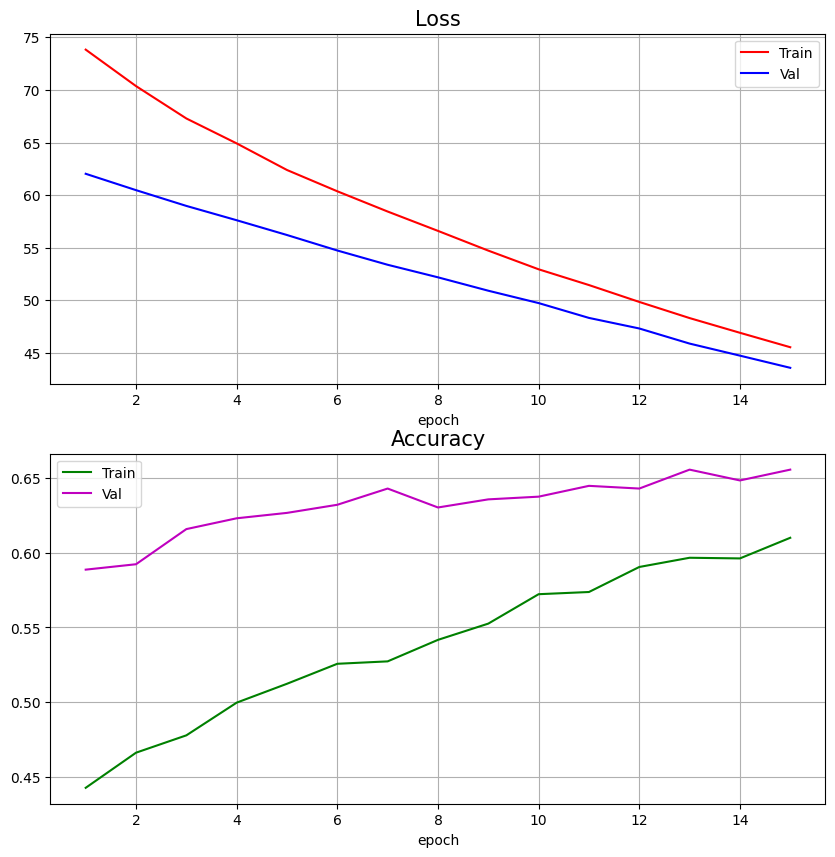

In [ ]:
train_loss=hist1.history['loss']
val_loss=hist1.history['val_loss']
train_acc=hist1.history['Accuracy']
val_acc=hist1.history['val_Accuracy']
epochs=[i for i in range(1,len(val_loss)+1)]
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(2,1,1)
ax1.set_title('Loss',fontsize=15)
ax1.plot(epochs,train_loss,color='r',label='Train')
ax1.plot(epochs,val_loss,color='b',label='Val')
ax1.set_xlabel('epoch')
ax1.grid()
ax1.legend()
ax2=fig.add_subplot(2,1,2)
ax2.set_title('Accuracy',fontsize=15)
ax2.plot(epochs,train_acc,color='g',label='Train')
ax2.plot(epochs,val_acc,color='m',label='Val')
ax2.set_xlabel('epoch')
ax2.grid()
ax2.legend()
plt.show()

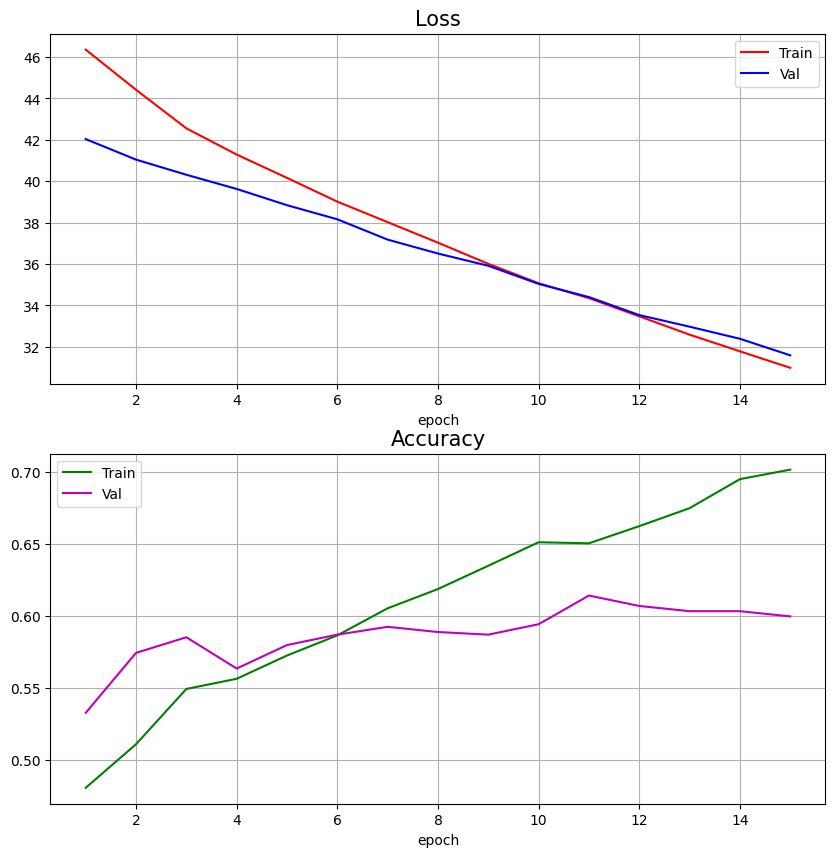

In [ ]:
train_loss=hist2.history['loss']
val_loss=hist2.history['val_loss']
train_acc=hist2.history['Accuracy']
val_acc=hist2.history['val_Accuracy']
epochs=[i for i in range(1,len(val_loss)+1)]
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(2,1,1)
ax1.set_title('Loss',fontsize=15)
ax1.plot(epochs,train_loss,color='r',label='Train')
ax1.plot(epochs,val_loss,color='b',label='Val')
ax1.set_xlabel('epoch')
ax1.grid()
ax1.legend()
ax2=fig.add_subplot(2,1,2)
ax2.set_title('Accuracy',fontsize=15)
ax2.plot(epochs,train_acc,color='g',label='Train')
ax2.plot(epochs,val_acc,color='m',label='Val')
ax2.set_xlabel('epoch')
ax2.grid()
ax2.legend()
plt.show()

In [ ]:
model1.save_weights('/kaggle/working/weights_2.h5')
model2.save_weights('/kaggle/working/weights_3.h5')